# MTG: Color Classifier

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For downloading the data
import requests

import json

# NLP

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

from wordcloud import WordCloud, get_single_color_func
from PIL import Image

# Splitting the data

from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import classification_report

# Helper functions
from helper_functions import plot_distribution

import warnings
warnings.filterwarnings('ignore')

# Hyperparamater Optimization
from sklearn.model_selection import GridSearchCV

# Table of Contents

1. [Introduction](#Introduction)
2. [Checking Distributions](#Checking-Distributions)
3. [Feature Engineering](#Feature-Engineering)
4. [NLP](#NLP)
5. [References](#References)

## Introduction

On August 5th, 1993, Wizards of the Coast released the first set of Magic: The Gathering, *Limited Edition Alpha*. This then unknown card game began with 295 cards. Today, it is one of the most popular trading card games, right up there with Yugioh and Pokemon TCG, with a cardbase exceeding 24,000 unique entries. 

In Magic, you the player are a 'planeswalker' (in layman terms, think of yourself as a spellcaster), your deck represents your spellbook, and the individual cards represent different spells. Each card contains a various bits of information: what your spell does, what it costs to cast it, the type of spell it is, et cetera. In this project, we will be looking at these features and fit them to a classification model, to determine our dependant: the color identity of the card.

### What do we mean by 'color identity'?

<div style="text-align: left; display: inline-block; margin-top: 1.5em;">
<img src="assets/fivecolors.jpg" style="height: 50px" >
</div>

There are 5 colors in MTG. We can also consider the absence of any color to be a 6th color identity. Cards with the same color identity will have similar themes, such as similar keywords. Cards can also be of multiple color identities. The aim of this project will be to train a model to recognize these patterns in the card's description, and other provided independants, to classify the card accordingly.

### The Dataset

I have obtained a dataset of all unique cards from [MTGJSON.com](https://mtgjson.com).

In [2]:
# You can use the code below to use our locally saved version of AtomicCards.json instead
# with open('data/AtomicCards.json') as f:
#    atomic_json = json.load(f)

r = requests.get("https://mtgjson.com/api/v5/AtomicCards.json")
atomic_json = r.json()

print("Meta:", atomic_json['meta']) 
print("Unique Cards:", len(atomic_json['data'].keys()))

Meta: {'date': '2022-08-07', 'version': '5.2.0+20220807'}
Unique Cards: 24733


Each unique card is represented by a dictionary of key-value pairs. Which keys are present will vary from card to card. For example, if a card is not a creature, there will be no mention of toughness or power.

In [3]:
# Output the keys of a creature card
print(atomic_json['data']['Goblin Guide'][0].keys())

dict_keys(['colorIdentity', 'colors', 'convertedManaCost', 'edhrecRank', 'foreignData', 'identifiers', 'keywords', 'layout', 'legalities', 'manaCost', 'manaValue', 'name', 'power', 'printings', 'purchaseUrls', 'rulings', 'subtypes', 'supertypes', 'text', 'toughness', 'type', 'types'])


There are certainly a lot of features, but we will be using the following as our independants:

* `manaValue`
* `name`
* `text`
* `power`
* `toughness`
* `types`
* `subtypes`

While it won't be used in the dataframe, we will be looking at `legalities` key to eliminate cards that have never been legal in a Standard MTG format. These includes cards from 'Un-sets' (joke sets) which don't follow traditional MTG design principles. 

In [4]:
# Initialize dataframe

features = ["colors","manaValue","text", "power", 
            "toughness", "types", "subtypes"]

df_original = pd.DataFrame(columns=features)

atomic_data = atomic_json['data']

for card in atomic_data:
    
    try:
        legalities = atomic_data[card][0]['legalities']
        if legalities == {} : continue # Skip card if it is illegal in any format
    except KeyError:
        continue
            
    row = []    
    
    for feature in features:
        try:
            row.append(atomic_data[card][0][feature])
        except KeyError:
            row.append(None)
    
    if row[5][0] == 'Conspiracy':
        continue
        
    
    df_original.loc[card] = row


In [5]:
df_original.reset_index(inplace=True)
df_original.rename(columns = {'index': 'name'}, inplace=True)
display(df_original.head())

,name,colors,manaValue,text,power,toughness,types,subtypes
0,+2 Mace,[W],2.0,Equipped creature gets +2/+2.\nEquip {3} ({3}:...,None,None,[Artifact],[Equipment]
1,A Little Chat,[U],2.0,"Casualty 1 (As you cast this spell, you may sa...",None,None,[Instant],[]
2,A-Acererak the Archlich,[B],3.0,When Acererak the Archlich enters the battlefi...,5,5,[Creature],"[Zombie, Wizard]"
3,A-Alrund's Epiphany,[U],7.0,Take an extra turn after this one. If this spe...,None,None,[Sorcery],[]
4,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",[U],5.0,Alrund gets +1/+1 for each card in your hand a...,1,1,[Creature],[God]


In [6]:
df_original.shape

(23630, 8)

Some data processing needs to be done here:


### Handling NaN values

In [7]:
df_original.isna().sum()

name             0
colors           0
manaValue        0
text           334
power        10753
toughness    10753
types            0
subtypes         0
dtype: int64

#### text

Some cards, usually creature cards, don't have any text associated with them. We will simply replace the NaN value with an empty string.

#### power & toughness

Non-creature cards typically do not have power or toughness. We will be using the value -1 to designate cards without power/toughness.


In [8]:
# handling text
df_original['text'] = df_original['text'].fillna('')

# handling power & toughness
df_original['power'] = df_original['power'].fillna(-1)
df_original['toughness'] = df_original['toughness'].fillna(-1)

df_original.head()

,name,colors,manaValue,text,power,toughness,types,subtypes
0,+2 Mace,[W],2.0,Equipped creature gets +2/+2.\nEquip {3} ({3}:...,-1,-1,[Artifact],[Equipment]
1,A Little Chat,[U],2.0,"Casualty 1 (As you cast this spell, you may sa...",-1,-1,[Instant],[]
2,A-Acererak the Archlich,[B],3.0,When Acererak the Archlich enters the battlefi...,5,5,[Creature],"[Zombie, Wizard]"
3,A-Alrund's Epiphany,[U],7.0,Take an extra turn after this one. If this spe...,-1,-1,[Sorcery],[]
4,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",[U],5.0,Alrund gets +1/+1 for each card in your hand a...,1,1,[Creature],[God]


In [9]:
df_original.isna().sum()

name         0
colors       0
manaValue    0
text         0
power        0
toughness    0
types        0
subtypes     0
dtype: int64

The columns `colors` and `types` are currently stored as lists, but ideally we don't want to work with lists when exploring/modelling our data later on. We will simply merge the lists into one string.

We will deliberarely leave `subtypes` as a list while examining its distribution.

In [10]:
df_original['colors'] = df_original['colors'].apply(lambda x: ''.join(sorted(x)))
df_original['types'] = df_original['types'].apply(lambda x: ' '.join(sorted(x)))

df_original.head()

,name,colors,manaValue,text,power,toughness,types,subtypes
0,+2 Mace,W,2.0,Equipped creature gets +2/+2.\nEquip {3} ({3}:...,-1,-1,Artifact,[Equipment]
1,A Little Chat,U,2.0,"Casualty 1 (As you cast this spell, you may sa...",-1,-1,Instant,[]
2,A-Acererak the Archlich,B,3.0,When Acererak the Archlich enters the battlefi...,5,5,Creature,"[Zombie, Wizard]"
3,A-Alrund's Epiphany,U,7.0,Take an extra turn after this one. If this spe...,-1,-1,Sorcery,[]
4,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",U,5.0,Alrund gets +1/+1 for each card in your hand a...,1,1,Creature,[God]


For reasons we will explain further below, it will be helpful for us to temporarily treat the `power` and `toughness` columns as a string. We will convert them back to numbers later on.

In [11]:
df_original['power'] = df_original['power'].astype(str)
df_original['toughness'] = df_original['toughness'].astype(str)

## Checking Distributions

### `colors` distribution

First we will be looking at the distribution of our target class:

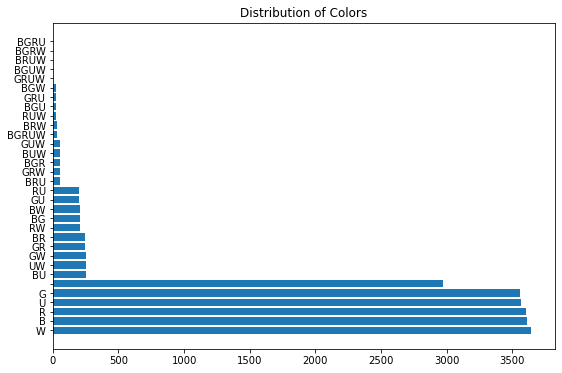

In [12]:
# Check for color distribution

plot_distribution(df_original,"colors",figsize=(9,6),title='Distribution of Colors')

We will end up with 6 classes: 5 representing the base colors (G,U,R,B,W), and one for colorless cards.

0. Colorless,
1. Green,
2. Blue,
3. Red,
4. Black,
5. White,

**A note about Multicolored cards**

In earlier versions of our project, multicolored cards were included as one of the predicted classes. In truth, there are no true design principles that are universal to all multicolored cards, and if our goal is to create an ML tool that will help designers adhere to design principals, we can safely ignore gold cards (who contain design elements of multiple colors).

Furthermore, while evaluating models that accounted for multicolored cards, the precision/recall for correctly predicting a multicolored cards was quite low (sub 50%) compared to other colors (70%). I have elected to drop all multicolor cards.

### `types` distribution

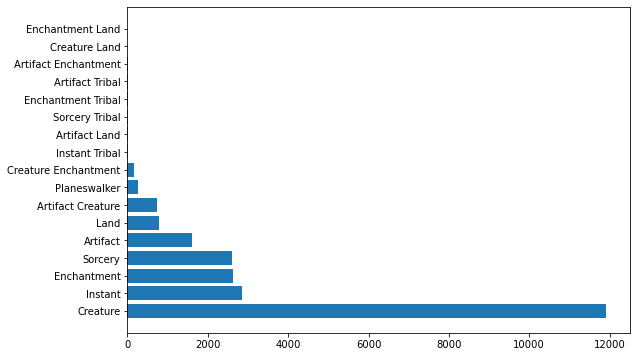

In [13]:
plot_distribution(df_original,'types',figsize=(9,6))

### `subtypes` distribution

We will convert `subtypes` to a string (but preserve it's original form as a list in the dataframe).

In [14]:
subtypes_series = df_original['subtypes'].apply(lambda x: ' '.join(sorted(x))).value_counts()

display(subtypes_series)

                      8631
Aura                  1010
Human Wizard           478
Human Soldier          405
Spirit                 382
                      ... 
Boar Equipment           1
Lolth                    1
Kor Monk                 1
Beast Elemental Ox       1
Advisor Kithkin          1
Name: subtypes, Length: 1665, dtype: int64

We have 1665 unique subtype combinations. Instead of converting this into 1665 dummy columns, where 'is Human Wizard' and 'is Human Soldier' are two different columns, we will instead use TransactionEncoder, where it will check for the presence of a token in the list.

### `power` and `toughness` distribution

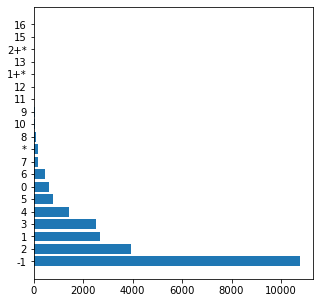

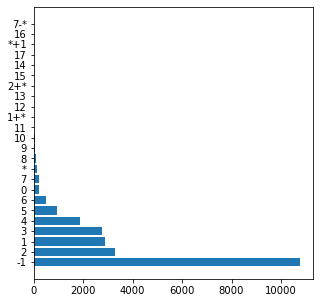

In [15]:
plot_distribution(df_original,'power')
plot_distribution(df_original,'toughness')

For some cards, there is an asterisk symbol in the power and toughness areas (see cards like Tarmogoyf). To prepare our data for the model, we will be substituting any card containing an asterisk with the manavalue of the card.

The reasoning behind doing this is from my domain knowledge the power (and toughness) of MTG cards is roughly connected to the manavalue of a card.

## Feature Engineering

- Reducing our dependant, `colors`, to 6 classes as described above, and dropping all multicolored cards.
- Removing asterisks from our `power` and `toughness` columns.
- We will merge `name` and `text` into one feature.

In [16]:
df_modified = df_original.copy()

df_modified['name_text'] = df_modified['name'] + ' ' + df_modified['text']
df_modified['name_text'] = df_modified['name_text'].apply(lambda x: x.replace('\n',' ')) 

df_modified.drop(columns=['text'], inplace=True)
df_modified.set_index('name', inplace=True)

df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,W,2.0,-1,-1,Artifact,[Equipment],+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,U,2.0,-1,-1,Instant,[],A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,B,3.0,5,5,Creature,"[Zombie, Wizard]",A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,U,7.0,-1,-1,Sorcery,[],A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",U,5.0,1,1,Creature,[God],"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


In [17]:
df_modified.loc[df_modified['power'].str.contains('\*'), 'power'] = df_modified[df_modified['power'].str.contains('\*')]['manaValue'].astype(int)

df_modified.loc[df_modified['toughness'].str.contains('\*'), 'toughness'] = df_modified[df_modified['toughness'].str.contains('\*')]['manaValue'].astype(int)


In [18]:
df_modified['power'] = df_modified['power'].astype(int)
df_modified['toughness'] = df_modified['toughness'].astype(int)

df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,W,2.0,-1,-1,Artifact,[Equipment],+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,U,2.0,-1,-1,Instant,[],A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,B,3.0,5,5,Creature,"[Zombie, Wizard]",A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,U,7.0,-1,-1,Sorcery,[],A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",U,5.0,1,1,Creature,[God],"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


In [19]:
color_map = {'': 0, 'G': 1, 'U': 2, 'R': 3, 'B': 4, 'W': 5}
    
df_modified['colors'] = df_modified['colors'].apply(lambda x: color_map.get(x, 6))

df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,5,2.0,-1,-1,Artifact,[Equipment],+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,2,2.0,-1,-1,Instant,[],A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,4,3.0,5,5,Creature,"[Zombie, Wizard]",A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,2,7.0,-1,-1,Sorcery,[],A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",2,5.0,1,1,Creature,[God],"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


In [20]:
## Dropping multicolored cards

df_modified = df_modified.drop(df_modified[df_modified['colors'] == 6].index)

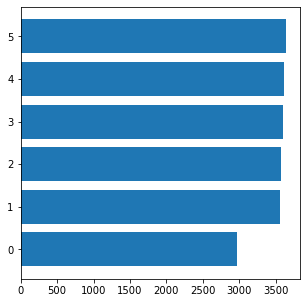

In [21]:
# Check for new color distribution

plot_distribution(df_modified, 'colors')

In [22]:
# Encoding our Subtypes

from mlxtend.preprocessing import TransactionEncoder


subtype_baskets = df_original['subtypes'].values
subtype_baskets

array([list(['Equipment']), list([]), list(['Zombie', 'Wizard']), ...,
       list(['Orc', 'Warrior']), list(['Orc', 'Warrior']),
       list(['Devil'])], dtype=object)

In [23]:
te = TransactionEncoder()
subtypes = te.fit_transform(subtype_baskets)
subtypes_encoded = pd.DataFrame(subtypes, columns=te.columns_)
subtypes_encoded.head()

# Add the names back in
subtypes_encoded['name'] = df_original['name']
subtypes_encoded.set_index('name', inplace=True)

subtypes_encoded.head()

,Advisor,Aetherborn,Ajani,Ally,Aminatou,Angel,Angrath,Antelope,Ape,Arcane,...,Wraith,Wrenn,Wurm,Xenagos,Yanggu,Yanling,Yeti,Zariel,Zombie,Zubera
name,,,,,,,,,,,,,,,,,,,,,
+2 Mace,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A Little Chat,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A-Acererak the Archlich,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
A-Alrund's Epiphany,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We have managed to reduce what would have been 1600 dummy variables to 341. We will now merge this back with the modified DF.

In [24]:
df_modified = df_modified.join(subtypes_encoded).drop('subtypes', axis=1)
df_modified.head()

,colors,manaValue,power,toughness,types,name_text,Advisor,Aetherborn,Ajani,Ally,...,Wraith,Wrenn,Wurm,Xenagos,Yanggu,Yanling,Yeti,Zariel,Zombie,Zubera
name,,,,,,,,,,,,,,,,,,,,,
+2 Mace,5,2.0,-1,-1,Artifact,+2 Mace Equipped creature gets +2/+2. Equip {3...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A Little Chat,2,2.0,-1,-1,Instant,A Little Chat Casualty 1 (As you cast this spe...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A-Acererak the Archlich,4,3.0,5,5,Creature,A-Acererak the Archlich When Acererak the Arch...,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
A-Alrund's Epiphany,2,7.0,-1,-1,Sorcery,A-Alrund's Epiphany Take an extra turn after t...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",2,5.0,1,1,Creature,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## NLP

We now have our modified dataset, with one exception: we haven't vectorized our data.

In [25]:
df_modified.head()

,colors,manaValue,power,toughness,types,name_text,Advisor,Aetherborn,Ajani,Ally,...,Wraith,Wrenn,Wurm,Xenagos,Yanggu,Yanling,Yeti,Zariel,Zombie,Zubera
name,,,,,,,,,,,,,,,,,,,,,
+2 Mace,5,2.0,-1,-1,Artifact,+2 Mace Equipped creature gets +2/+2. Equip {3...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A Little Chat,2,2.0,-1,-1,Instant,A Little Chat Casualty 1 (As you cast this spe...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A-Acererak the Archlich,4,3.0,5,5,Creature,A-Acererak the Archlich When Acererak the Arch...,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
A-Alrund's Epiphany,2,7.0,-1,-1,Sorcery,A-Alrund's Epiphany Take an extra turn after t...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",2,5.0,1,1,Creature,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
token_re = r"(?u)\b\w\w+\b|[\+|\-]\w\/[\+|\-]\w"

# 1. Instantiate 
bagofwords = CountVectorizer(stop_words='english',
                             ngram_range=(1, 3)
                             ,min_df=5, token_pattern=token_re)

# 2. Fit 
bagofwords.fit(df_modified['name_text'])

# 3. Transformed
all_cards_counts = bagofwords.transform(df_modified['name_text'])


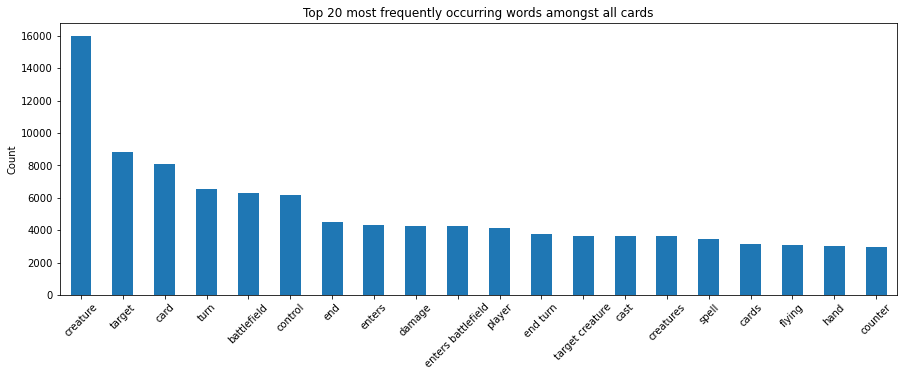

In [27]:
wc_df = pd.DataFrame(
        {"counts": all_cards_counts.toarray().sum(axis=0)},
        index=bagofwords.get_feature_names()
    ).sort_values("counts", ascending=False)

wc_df.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title(f"Top 20 most frequently occurring words amongst all cards")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Based on my own domain of MTG, and as you can see above, there are certain words that can easily appear across all cards with high frequency (creature, target, battlefield, etc.) that have little influence on the color identity of the card. We will be defining our own custom stopwords list that omits these tokens.

In [28]:
f = open("data/mtg_stopwords.txt","r")
mtg_stopwords = f.read().splitlines()

custom_stop_words = ENGLISH_STOP_WORDS.union(mtg_stopwords)

In [29]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words=custom_stop_words,
                             ngram_range=(1, 3),
                             min_df=5,
                             token_pattern=token_re)

# 2. Fit 
bagofwords.fit(df_modified['name_text'])

# 3. Transform

word_counts = []

for c in range(7):
    transformed = bagofwords.transform(df_modified[df_modified['colors'] == c]['name_text'])
    word_counts.append(transformed)

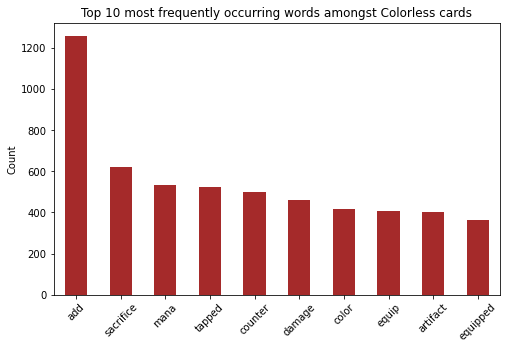

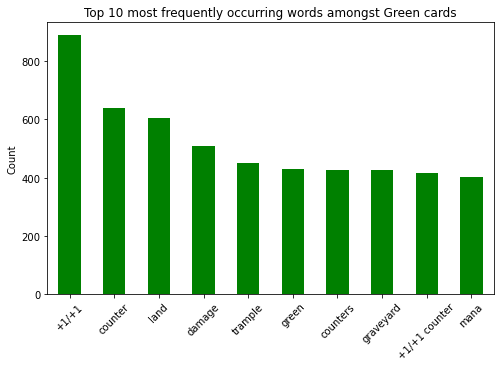

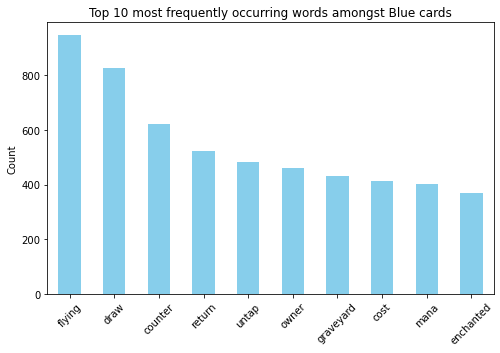

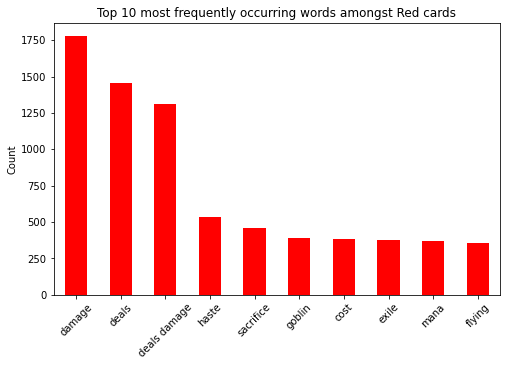

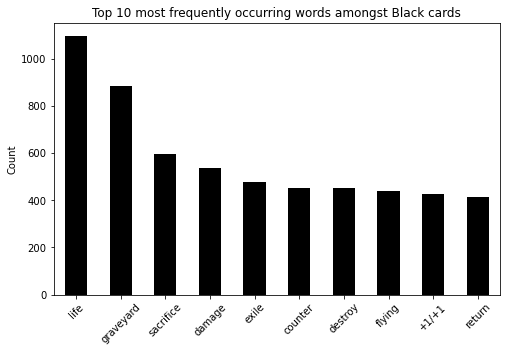

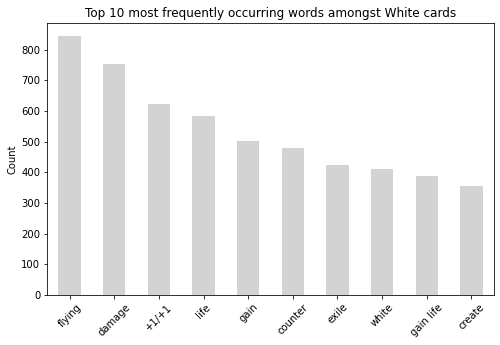

In [30]:
target_classes = ['Colorless','Green','Blue','Red','Black','White']
color_codes = ['brown','green','skyblue','red','black','lightgray']

frequency_dfs = []

for c in range(6):
    
    wc_df = pd.DataFrame(
        {"counts": word_counts[c].toarray().sum(axis=0)},
        index=bagofwords.get_feature_names()
    ).sort_values("counts", ascending=False)

    wc_df.head(10).plot(kind="bar", figsize=(8, 5), legend=False, color=color_codes[c] )
    plt.title(f"Top 10 most frequently occurring words amongst {target_classes[c]} cards")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.savefig(f'visualizations/freqcharts/{target_classes[c]}.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    frequency_dfs.append(wc_df)

For better visualization, I will be using the WordCloud library:

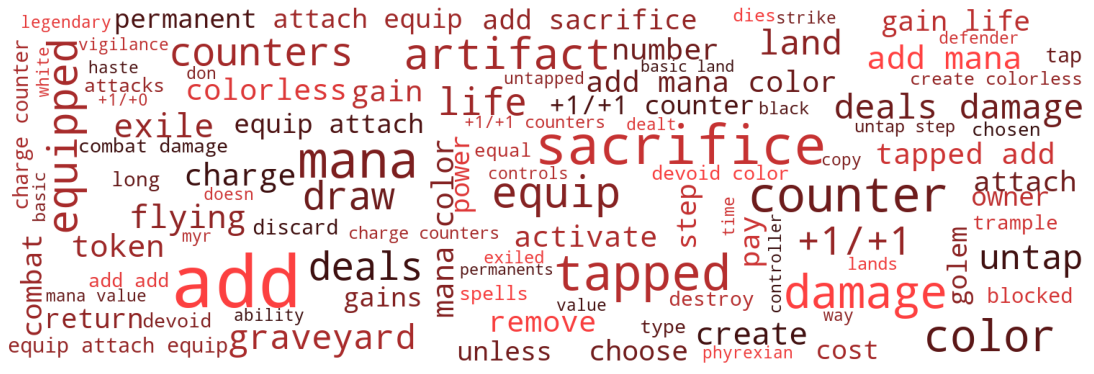

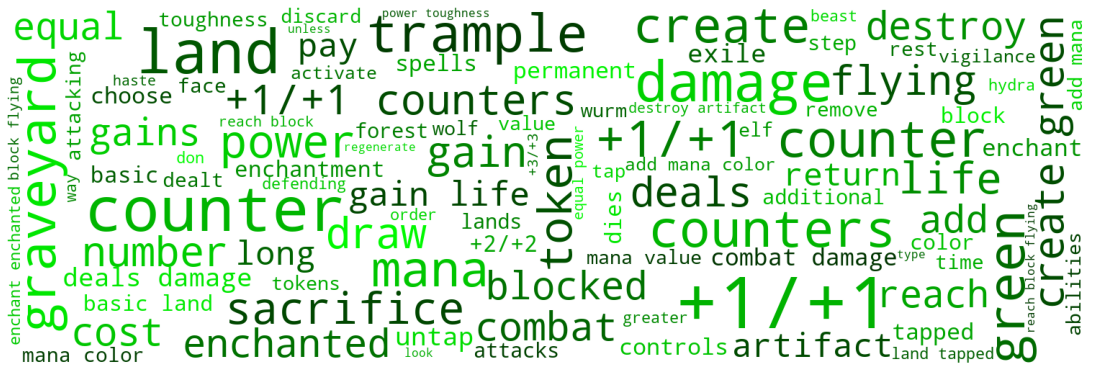

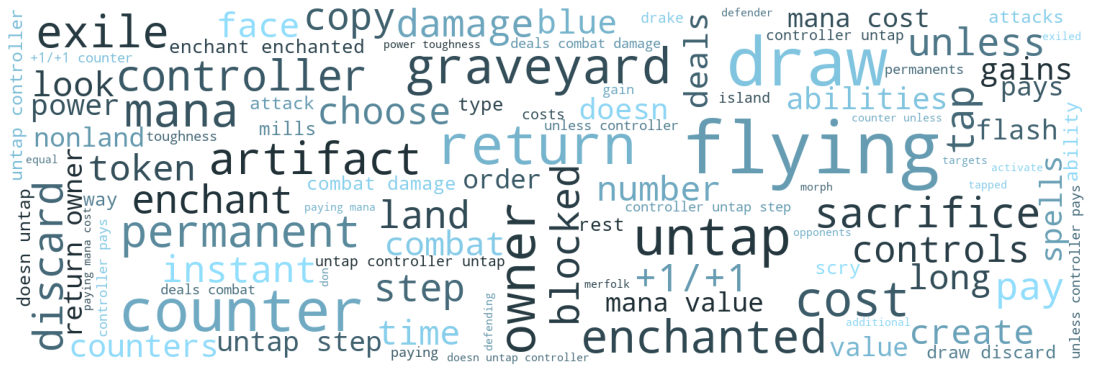

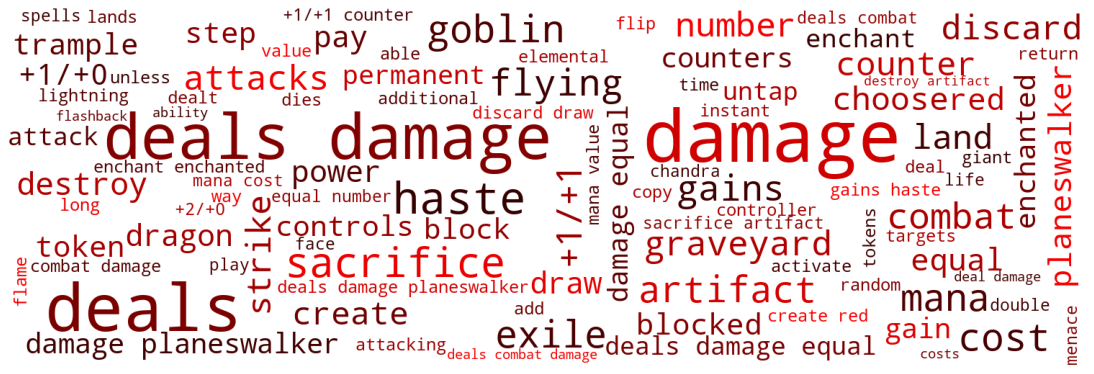

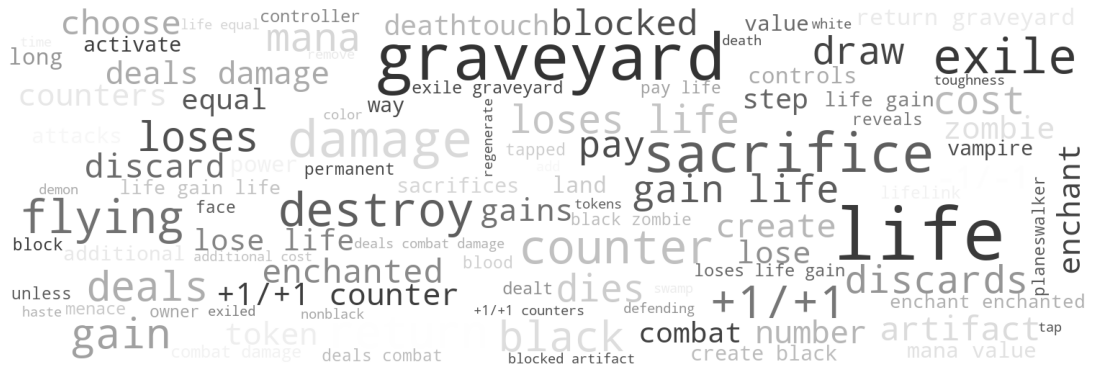

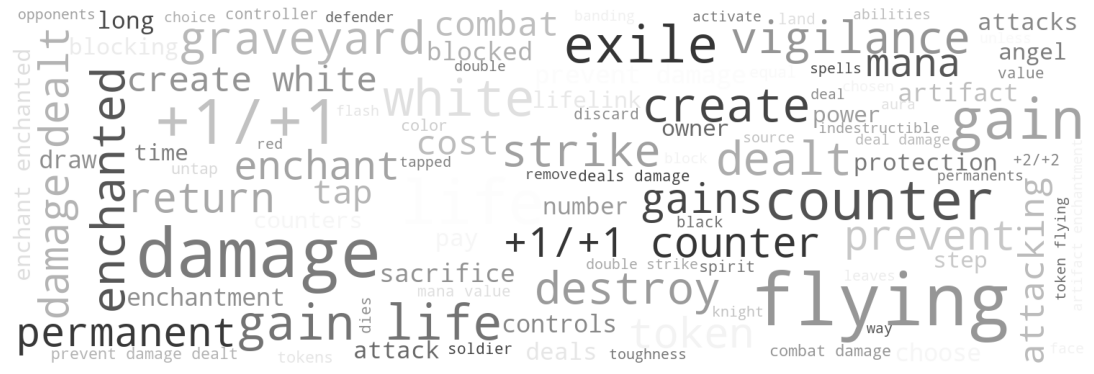

In [31]:
for i in range(6):

    data = dict(zip(frequency_dfs[i].index.tolist(), frequency_dfs[i]['counts'].tolist()))
    
    wc = WordCloud(width=1500, height=500, max_words=100, max_font_size=100, 
                   background_color='white').generate_from_frequencies(data)
 
    # generate color function
    color_func = get_single_color_func(color_codes[i])

    # plot the WordCloud image                      
    plt.figure(figsize=(15,5))
    plt.imshow(wc.recolor(color_func=color_func))
    plt.axis("off")
    
    plt.tight_layout(pad = 0)

    plt.show()
    
    wc.to_file(f'visualizations/wordclouds/{target_classes[i]}_wordcloud.png')

## Preparing For Modeling

In [32]:
X = df_modified.drop(columns='colors')
y = df_modified['colors']

In [33]:
# Dummify the types column

X = pd.get_dummies(X,columns=['types'])


It's import we split the data into the test-train split at this juncture, before vectorizing our data. The reason for this is we should not be exposing our model to our test set.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)


In [35]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words=custom_stop_words
                             ,ngram_range=(1, 3)
                             ,min_df=5
                             ,token_pattern=token_re)

# 2. Fit 
bagofwords.fit(X_train['name_text'])

# 3. Transform

name_text_transformed = bagofwords.transform(X_train['name_text'])

column_names = [('text_' + x) for x in bagofwords.get_feature_names()]

sparse_df = pd.DataFrame.sparse.from_spmatrix(name_text_transformed, columns=column_names, )
sparse_df['name'] = X_train.index
sparse_df.set_index('name', inplace=True)

In [36]:
name_text_transformed.shape

(14662, 7165)

In [37]:

X_train_vectorized = pd.concat([X_train, sparse_df], axis=1)
X_train_vectorized.drop(columns='name_text',inplace=True)

X_train_vectorized.head()

,manaValue,power,toughness,Advisor,Aetherborn,Ajani,Ally,Aminatou,Angel,Angrath,...,text_zombie gains,text_zombie graveyard,text_zombie token,text_zombie token decayed,text_zombie tokens,text_zombies,text_zone,text_zone game,text_zubera,text_zubera dies
name,,,,,,,,,,,,,,,,,,,,,
Cruel Bargain,3.0,-1,-1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
One with Nature,1.0,-1,-1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
Waterspout Elemental,5.0,3,4,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
Obelisk of Esper,3.0,-1,-1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
Hand of Silumgar,2.0,2,1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Transform the test data based on the vectorizer fitted on the train data

name_text_transformed = bagofwords.transform(X_test['name_text'])

column_names = [('text_' + x) for x in bagofwords.get_feature_names()]

sparse_df = pd.DataFrame.sparse.from_spmatrix(name_text_transformed, columns=column_names)
sparse_df['name'] = X_test.index
sparse_df.set_index('name', inplace=True)

X_test_vectorized = pd.concat([X_test, sparse_df], axis=1)
X_test_vectorized.drop(columns='name_text',inplace=True)

In [39]:
# Scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_vectorized)
X_train_scaled = scaler.transform(X_train_vectorized)
X_test_scaled = scaler.transform(X_test_vectorized)

In [40]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate model
LR_model = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)

# 2. Fit model
LR_model.fit(X_train_vectorized, y_train);

In [41]:
print("Train Score: ",LR_model.score(X_train_vectorized, y_train))
print("Test Score: ",LR_model.score(X_test_vectorized, y_test))

Train Score:  0.9558723230118674
Test Score:  0.8055688146380271


In [42]:
# 1. Instantiate model
LR_model_scaled = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)

# 2. Fit model
LR_model_scaled.fit(X_train_scaled, y_train);

In [43]:
print("Train Score: ",LR_model_scaled.score(X_train_scaled, y_train))
print("Test Score: ",LR_model_scaled.score(X_test_scaled, y_test))

Train Score:  0.9959759923612058
Test Score:  0.7204455051710421


In [44]:
# Obtain cross validation scores for LR (unscaled)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(LR_model, X_train_vectorized, y_train, cv = 5)

In [45]:
scores.mean()

0.7969581685380035

Notice how our base model with logistic regression performs better without scaling.

In [46]:
y_pred = LR_model.predict(X_test_vectorized) 

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       869
           1       0.76      0.76      0.76      1057
           2       0.78      0.79      0.79      1082
           3       0.78      0.79      0.79      1063
           4       0.84      0.78      0.81      1108
           5       0.76      0.77      0.76      1106

    accuracy                           0.81      6285
   macro avg       0.81      0.81      0.81      6285
weighted avg       0.81      0.81      0.81      6285



In [47]:
probabilities_df = pd.DataFrame(LR_model.predict_proba(X_test_vectorized)
                                , columns=LR_model.classes_
                                , index=X_test_vectorized.index) 

probabilities_df['Actual Class'] = y_test
probabilities_df['Predicted Class'] = LR_model.predict(X_test_vectorized)
probabilities_df.sample(n = 5)

,0,1,2,3,4,5,Actual Class,Predicted Class
name,,,,,,,,
Chandra's Outrage,0.004368,0.016740,0.012734,0.914696,0.040457,0.011005,3,3
Hammer of Purphoros,0.571916,0.137116,0.007162,0.185921,0.046949,0.050937,3,0
Declare Dominance,0.001930,0.945376,0.003031,0.036249,0.010264,0.003150,1,1
Rural Recruit,0.000023,0.931989,0.000243,0.002647,0.002332,0.062766,1,1
Nim Deathmantle,0.632951,0.000372,0.000073,0.000757,0.354443,0.011404,0,0


In [48]:
def plot_probabilities(df, name):
    temp = df[df.index == name]
    
    plt.figure(figsize=(10,5))
    
    for i in range(6):
        plt.bar(target_classes[i],temp[i],color=color_codes[i])
    
    plt.title(f'Probability Plot for {name}')
    plt.savefig(f'visualizations/probplots/{name}.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    

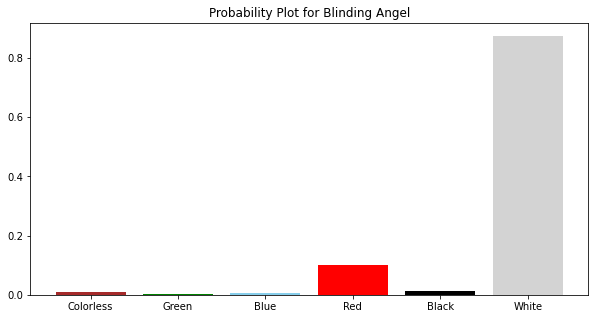

In [49]:
plot_probabilities(probabilities_df, 'Blinding Angel')

For our initial takeaway, we can see our model is excellent at identifying colorless cards but has terrible performance at correctly identifying multicolored cards. We will see if this is the case with further modelling.

## Further Modelling

Small note on scaling: I have tried several of the below models with scaled data (resulting in poor performance) and have elected to continue modelling using unscaled data.

### KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=41)
KNN_model.fit(X_train_scaled, y_train);

print("KNN(train): ",KNN_model.score(X_train_vectorized, y_train))
print("KNN (test): ",KNN_model.score(X_test_vectorized, y_test))

KNN(train):  0.18653662528986495
KNN (test):  0.1907716785998409


### Decision Trees

In [51]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_vectorized, y_train);

print("Decision Tree (train): ",DT_model.score(X_train_vectorized, y_train))
print("Decision Tree (test): ",DT_model.score(X_test_vectorized, y_test))

Decision Tree (train):  0.9989087436911744
Decision Tree (test):  0.6771678599840891


### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(X_train_vectorized, y_train)
 
print(f"Random Forest (train): {random_forest_model.score(X_train_vectorized, y_train)}")
print(f"Random Forest (test): {random_forest_model.score(X_test_vectorized, y_test)}")

Random Forest (train): 0.9988405401718728
Random Forest (test): 0.7517899761336515


In [53]:
#params = {'n_estimators': [100],
#          'max_depth' : [100,110,120,130,140,150]}

#grid_search = GridSearchCV(random_forest_model, param_grid=params)

    
#fitted_search = grid_search.fit(X_train_vectorized, y_train)

In [54]:
#print("Random forest with GridSearch", fitted_search.score(X_test_vectorized, y_test))

#fitted_search.best_estimator_

### XGBoost

In [55]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(n_estimators=100, max_depth=110)
XGB_model.fit(X_train_vectorized, y_train)

[19:01:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=110, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [56]:
print(f"XG Boost score (train): {XGB_model.score(X_train_vectorized, y_train)}")
print(f"XG Boost score (test): {XGB_model.score(X_test_vectorized, y_test)}")

XG Boost score (train): 0.9980903014595554
XG Boost score (test): 0.7826571201272872


I have tried different models but it appears our initial logistic regression model performs the best. I have elected to use GridSearchCV to tune this model further.

### Tuning Our LR Model using GridSearchCV

Grid search performs *incredibly* slowly with logistic regression (at least on my computer, with this dataset). Run the below section of code at your own risk:

In [57]:
#params = {'C': [0.01,0.1,1]}

#grid_search = GridSearchCV(LR_model, param_grid=params)

    
#fitted_search = grid_search.fit(X_train_vectorized, y_train)


# I ran this section of code as well, and got the same result
# params = {'C': [1,10,100]}
# grid_search = GridSearchCV(LR_model, param_grid=params)    
# fitted_search = grid_search.fit(X_train_vectorized, y_train)


In [58]:
#print(fitted_search.score(X_test_vectorized, y_test))

#fitted_search.best_estimator_

As unlikely as it is, even after hyperparamater tuning, our initial logistic regression model with C=1 still seems to perform the best.

## Model Evaluation

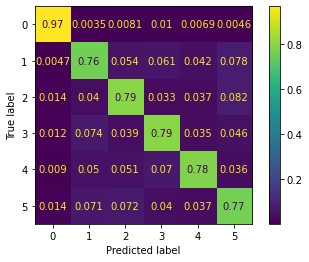

In [59]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(LR_model, X_test_vectorized, y_test, normalize='true');

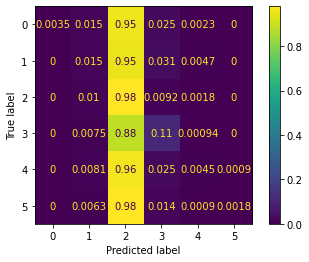

In [60]:
plot_confusion_matrix(KNN_model, X_test_vectorized, y_test, normalize='true');

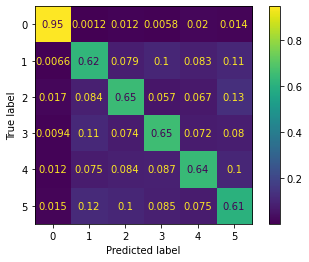

In [61]:
plot_confusion_matrix(DT_model, X_test_vectorized, y_test, normalize='true');

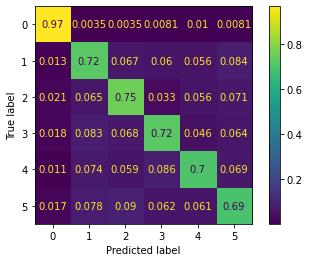

In [62]:
plot_confusion_matrix(random_forest_model, X_test_vectorized, y_test, normalize='true');

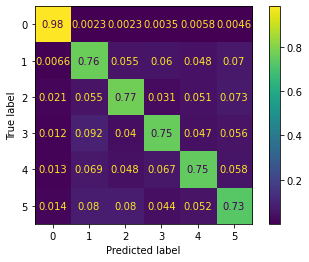

In [63]:
plot_confusion_matrix(XGB_model, X_test_vectorized, y_test, normalize='true');

Evaluation summary:
- KNN performs atrociously in this scenario, over predicting class 2 (blue cards) for some reason.
- XGBoost is the closest contender to logistic regression, but our XGB model has 99% performance on the train set, which is almost certainly indicative of overfitting.

### Interpreting Our LR Model

In [64]:
coef_df = pd.DataFrame(LR_model.coef_.T).set_index(LR_model.feature_names_in_)
coef_df.head()

,0,1,2,3,4,5
manaValue,0.044091,-0.116899,0.084103,0.009168,0.043812,-0.064276
power,-0.062142,0.226987,-0.261154,0.233187,0.110038,-0.246916
toughness,0.085440,0.008999,0.161871,-0.295574,-0.110804,0.150067
Advisor,-0.025640,-0.456830,0.051023,0.062551,-0.581842,0.950738
Aetherborn,-0.016082,-0.331389,-0.180333,-0.369473,1.169773,-0.272495


Using this coefficient dataframe, I will be able to investigate certain words that have an association with specific colors.

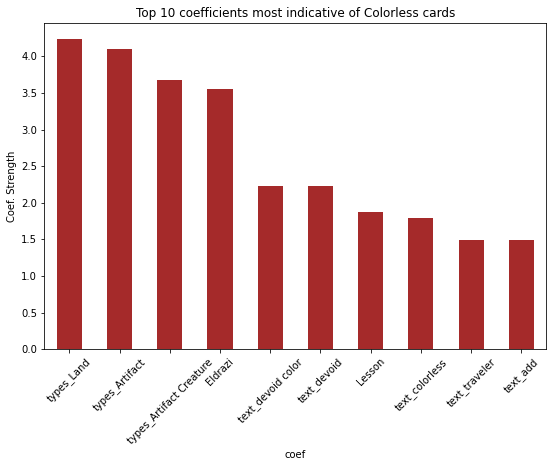

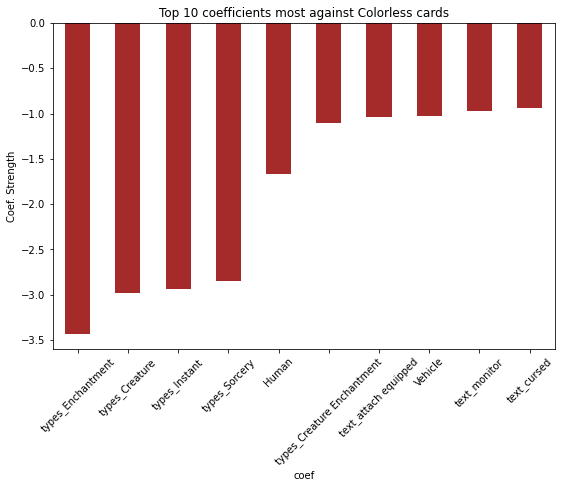

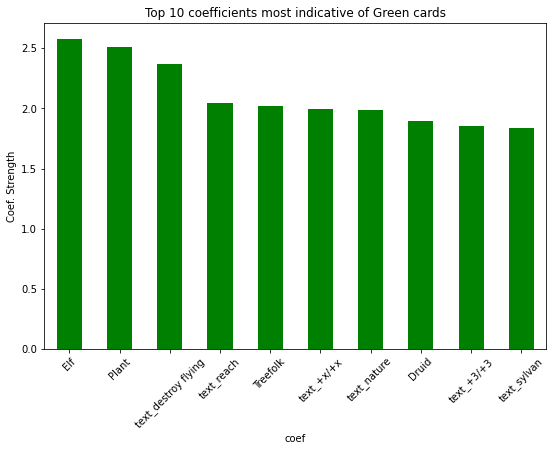

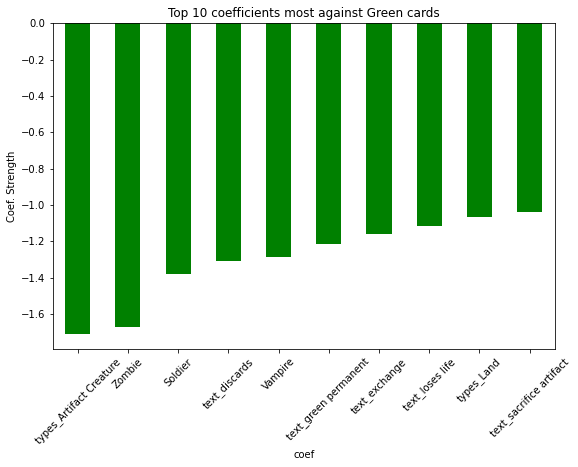

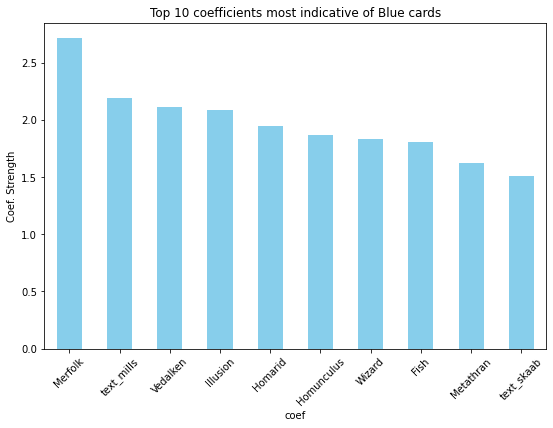

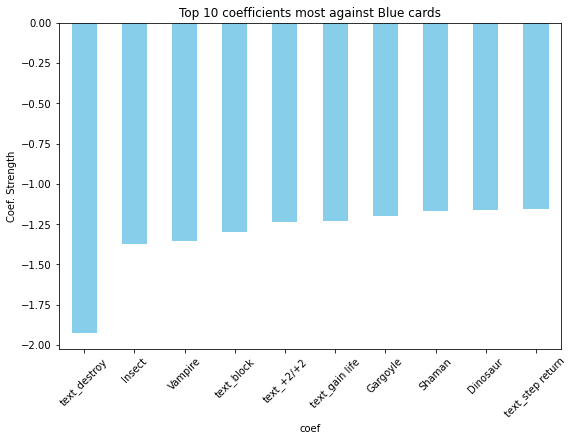

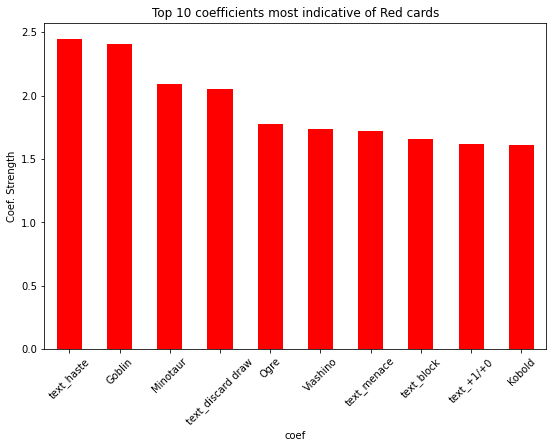

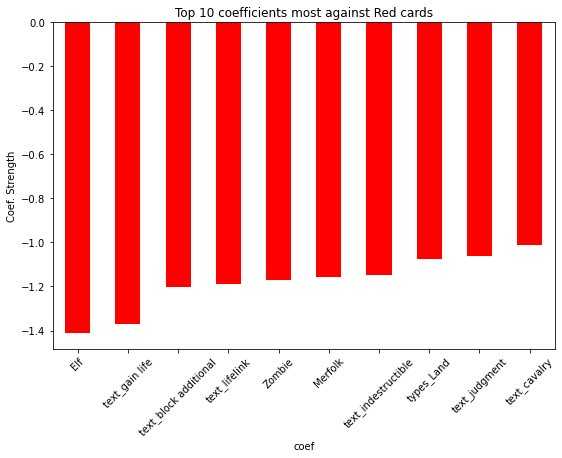

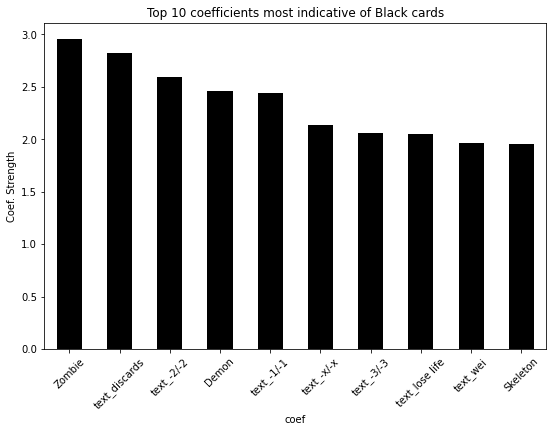

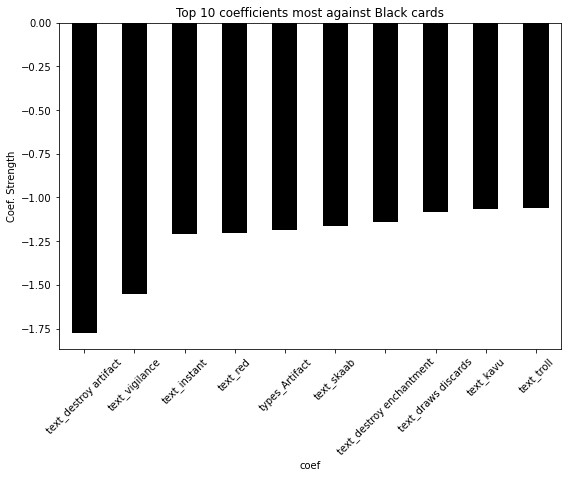

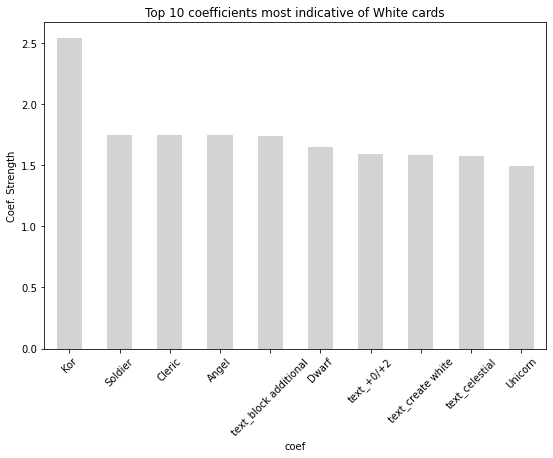

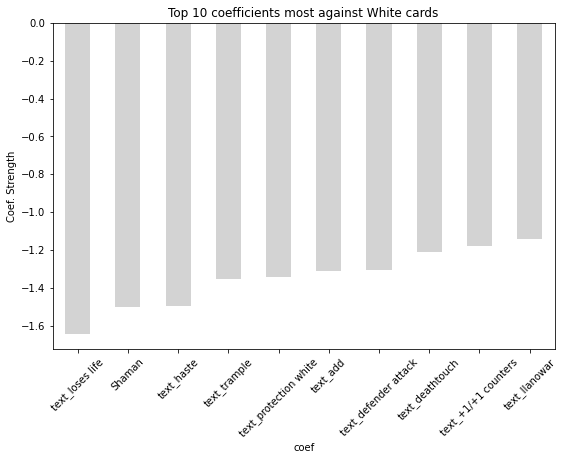

In [71]:
for c in range(6):
    
    temp_df = coef_df[c]
    

    temp_df.sort_values(ascending=False).head(10).plot(kind="bar", figsize=(9, 6), legend=False, color=color_codes[c] )
    plt.title(f"Top 10 coefficients most indicative of {target_classes[c]} cards")
    plt.ylabel("Coef. Strength")
    plt.xticks(rotation=45)
    plt.savefig(f'visualizations/coefcharts/top_{target_classes[c]}.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    temp_df.sort_values(ascending=True).head(10).plot(kind="bar", figsize=(9, 6), legend=False, color=color_codes[c] )
    plt.title(f"Top 10 coefficients most against {target_classes[c]} cards")
    plt.ylabel("Coef. Strength")
    plt.xticks(rotation=45)
    plt.savefig(f'visualizations/coefcharts/bottom_{target_classes[c]}.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    

It is hard to give a complete summary without going too much into detail about Magic: the Gathering design. Based off my own domain knowledge, what the model is picking up is very similar to what I already assume about certain colors.

Major takeaways:
- Subtypes are some of the strongest indicators of certain colors. Elves are green, goblins are red, and fish are blue.
- Keywords that are strong indicators of one color can be strong indicators against another color. Haste is a strong indicator of red but a strong indicator against white.


### Identifying Color Pie Breaks

In [66]:
design_breaks_df = probabilities_df[probabilities_df['Actual Class'] != 
                                    probabilities_df['Predicted Class']].sample(10, random_state=12)

design_breaks_df

,0,1,2,3,4,5,Actual Class,Predicted Class
name,,,,,,,,
Hunted Horror,0.001349,9.724622e-01,0.000380,0.000528,0.023022,0.002259,4,1
Shortcut Seeker,0.000047,6.328844e-02,0.396044,0.006170,0.061009,0.473440,2,5
Ice Cage,0.000192,1.205395e-02,0.001037,0.000624,0.003381,0.982713,2,5
Magnetic Theft,0.001609,1.844487e-02,0.122895,0.348089,0.029868,0.479094,3,5
"Hidetsugu, Devouring Chaos",0.000003,8.833700e-07,0.000002,0.999644,0.000346,0.000004,4,3
Shrink,0.006939,2.310219e-01,0.252593,0.118479,0.144940,0.246027,1,2
Hydroblast,0.006995,9.573882e-03,0.162776,0.663565,0.006357,0.150734,2,3
Introduction to Annihilation,0.010450,2.354619e-03,0.210188,0.016820,0.008233,0.751956,0,5
Fractured Loyalty,0.001727,1.878269e-02,0.764128,0.150752,0.029122,0.035488,3,2


In [67]:
from PIL import Image
from io import BytesIO

for name in design_breaks_df.index:
    r = requests.get(f"https://api.scryfall.com/cards/search?q={name}")
    image_link = r.json()['data'][0]['image_uris']['large']
    print(name,":",image_link)

Hunted Horror : https://c1.scryfall.com/file/scryfall-cards/large/front/0/2/02f74866-d0ea-42ce-bc44-500219fb73d4.jpg?1654116158
Shortcut Seeker : https://c1.scryfall.com/file/scryfall-cards/large/front/1/2/122d2635-c4f4-44cd-8f82-37e3016e421e.jpg?1627703755
Ice Cage : https://c1.scryfall.com/file/scryfall-cards/large/front/a/5/a5e14b62-c050-4d43-aeee-873f46d1e295.jpg?1562654028
Magnetic Theft : https://c1.scryfall.com/file/scryfall-cards/large/front/d/e/de0c1e37-fedc-43d9-97fd-b797c6c2fbbe.jpg?1562880223
Hidetsugu, Devouring Chaos : https://c1.scryfall.com/file/scryfall-cards/large/front/6/f/6f4142d3-f7ca-4613-a6e5-528cf1f22383.jpg?1654567158
Shrink : https://c1.scryfall.com/file/scryfall-cards/large/front/c/4/c4e319d7-53f3-40e8-9a75-fe1fd8716733.jpg?1562870478
Hydroblast : https://c1.scryfall.com/file/scryfall-cards/large/front/4/c/4c9c9b16-5567-4473-95e6-622292f77336.jpg?1580013995
Introduction to Annihilation : https://c1.scryfall.com/file/scryfall-cards/large/front/b/0/b0bc4682-bca

Analysis of these color breaks will be shown in my slides.

### Exporting Our Models

We will be exporting our models and build a Streamlit to demo them.

In [68]:
import joblib

joblib.dump(te, "models/subtype_encoder.pkl")
joblib.dump(bagofwords, "models/count_vectorizer.pkl")
joblib.dump(LR_model, "models/mtg_logit.pkl")

['models/mtg_logit.pkl']

We will be exporting our modified dataset (prior to word vectorizing). The reason for doing this is so that we have a complete dataset of all the cards prior to the test/train split. We will also be exporting our coefficients dataframe.

In [69]:
X.to_csv('data/all_cards.csv')

coef_df.index.name = 'coef'

coef_df.to_csv('data/coef.csv')

## References

Inspired by the repository [MTG Color Classifier](https://github.com/Yee-Brian21/MTG-Color-Classifier) by Github user [Yee-Brian21](https://github.com/Yee-Brian21).

Credit to the following StackOverflows posts for:

- Figuring out how to convert a dataframe to be used with WordCloud:
    - https://stackoverflow.com/questions/57826063/how-to-create-a-wordcloud-according-to-frequencies-in-a-pandas-dataframe